In [1]:
import numpy
import sklearn.metrics
import tensorflow
import time

# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
"""Load some data."""
(xraw_train, yraw_train), (xraw_test, yraw_test) = tensorflow.keras.datasets.fashion_mnist.load_data()

xraw_train.shape, yraw_train.shape, xraw_test.shape, yraw_test.shape, xraw_train.dtype, xraw_train.max()

4422102/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), dtype('uint8'), 255)

In [3]:
def sample_from_validation_set(x_valid_all,y_raw_test):
  print("first" ,x_valid_all.shape)
  vis_x_valid = x_valid_all[:250,:,:,:]
  vis_y_valid = yraw_test[:250]
  counts = numpy.zeros((11,))
  index_to_delete = []
  #print(counts)
  print("vis_x_valid shape ",vis_x_valid.shape)
  for i in range(len(vis_y_valid)):
    label = vis_y_valid[i]
    if(counts[label]<15):
      counts[label] += 1
    else:
      index_to_delete.append(i)
  #print(index_to_delete)
  vis_y_valid = numpy.delete(vis_y_valid,index_to_delete)
  vis_x_valid = numpy.delete(vis_x_valid,index_to_delete,axis=0)
  #print("Label count: ",numpy.unique(vis_y_valid,return_counts = True))
  print("before return ",vis_x_valid.shape)
  return vis_x_valid,vis_y_valid

In [15]:
"""Preprocess the data.

In addition, shuffle the data.
Set the random seed (so we can replicate the experiment).
"""
batch_size = 32

# Training Set
x_train_all = xraw_train.astype('float32').reshape(-1, 28, 28, 1)/255
y_train_all = tensorflow.one_hot(yraw_train, 10).numpy().astype('int32')
print(y_train_all.shape)
train_dataset = tensorflow.data.Dataset.from_tensor_slices((x_train_all, y_train_all))
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=56).batch(batch_size)

# Validation Set
x_valid_all = xraw_test.astype('float32').reshape(-1, 28, 28, 1)/255
print(x_valid_all.shape)
y_valid_all = tensorflow.one_hot(yraw_test, 10).numpy().astype('int32')
valid_dataset = tensorflow.data.Dataset.from_tensor_slices((x_valid_all, y_valid_all)).batch(batch_size)
vis_x_valid,vis_y_valid = sample_from_validation_set(x_valid_all,yraw_test)

(60000, 10)
(10000, 28, 28, 1)
first (10000, 28, 28, 1)
vis_x_valid shape  (250, 28, 28, 1)
before return  (150, 28, 28, 1)


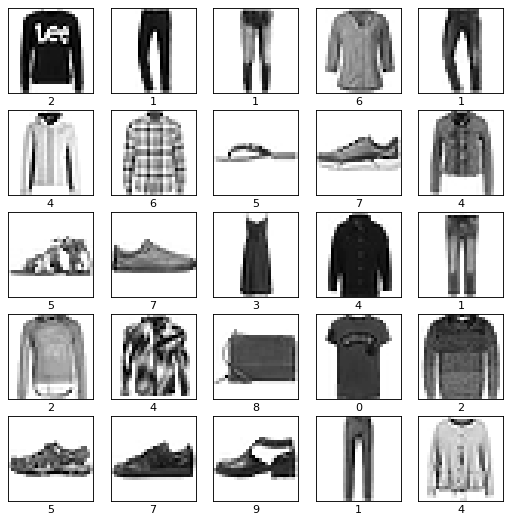

In [16]:
"""Show examples."""
class_names = list(range(10))
offset = 1
one_batch = next(iter(valid_dataset.take(1)))

plt.figure(figsize=(8, 8), dpi=80)
for i in range(25):
    plt.subplot(5, 5, i+1)
    x, y = one_batch
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(x[i + offset], cmap=plt.cm.binary)
    plt.xlabel(class_names[numpy.argmax(y[i + offset])])

plt.show()

In [17]:
class ModelGradient():
  def assignGradients(self,gradient_list):
    self.conv1_grad = gradient_list[0]
    #self.conv1_grad_bias = gradient_list[1]
    self.conv2_grad = gradient_list[2]
    #self.conv2_grad_bias = gradient_list[3]
    self.flatten1_grad = gradient_list[4]
    #self.flatten1_grad_bias = gradient_list[5]
    self.flatten2_grad = gradient_list[6]
    self.pred_grad = gradient_list[7]

  def __init__(self):
    self.conv1_grad = tensorflow.zeros((5,5,1,128))
    #self.conv1_grad_bias = tensorflow.zeros((128,))
    self.conv2_grad = tensorflow.zeros((7,7,128,128))
    #self.conv2_grad_bias = tensorflow.zeros((128,))
    self.flatten1_grad = tensorflow.zeros((1152,512))
    #self.flatten1_grad_bias = tensorflow.zeros((512,))
    self.flatten2_grad = tensorflow.zeros((512,10))
    self.pred_grad = tensorflow.zeros((10,))


class ModelWeights():
  def assignWeights(self,model_string,weight_list):
    self.model_name = model_string
    self.conv1_weights = weight_list[0]
    #self.conv1_weights_bias = weight_list[1]
    self.conv2_weights = weight_list[2]
    #self.conv2_weights_bias = weight_list[3]
    self.flatten1_weights = weight_list[4]
    #self.flatten1_weights_bias = weight_list[5]
    self.flatten2_weights = weight_list[6]
    self.pred_weights = weight_list[7]

  def __init__(self):
    self.conv1_weights = tensorflow.zeros((5,5,1,128))
    #self.conv1_weight_bias = tensorflow.zeros((128,))
    self.conv2_weights = tensorflow.zeros((7,7,128,128))
    #self.conv2_weight_bias = tensorflow.zeros((128,))
    self.flatten1_weights = tensorflow.zeros((1152,512))
    #self.flatten1_weights_bias = tensorflow.zeros((512,))
    self.flatten2_weights = tensorflow.zeros((512,10))
    self.pred_weights = tensorflow.zeros((10,))





# shape=(5, 5, 1, 128) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/conv2d/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/conv2d_1/Conv2D/Conv2DBackpropFilter:0' shape=(7, 7, 128, 128) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/conv2d_1/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/dense/MatMul/MatMul_1:0' shape=(1152, 512) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/dense/BiasAdd/BiasAddGrad:0' shape=(512,) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/predictions/MatMul/MatMul_1:0' shape=(512, 10) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/predictions/BiasAdd/BiasAddGrad:0' shape=(10,) dtype=float32>

# Model weights shape :  (5, 5, 1, 128)
# Model weights shape :  (128,)
# Model weights shape :  (7, 7, 128, 128)
# Model weights shape :  (128,)
# Model weights shape :  (1152, 512)
# Model weights shape :  (512,)
# Model weights shape :  (512, 10)
# Model weights shape :  (10,)


class ControlVariate():
  def __init__(self):
    self.conv1_c = tensorflow.zeros((5,5,1,128))
    #self.conv1_bias_c = tensorflow.zeros((128,))
    self.conv2_c = tensorflow.zeros((7,7,128,128))
    #self.conv2_bias_c = tensorflow.zeros((128,))
    self.flatten1_c = tensorflow.zeros((1152,512))
    #self.flatten1_bias_c = tensorflow.zeros((512,))
    self.flatten2_c = tensorflow.zeros((512,10))
    self.pred_c = tensorflow.zeros((10,))


def add_to_control_variate(weight_obj,c_obj):
  new_c = ControlVariate()
  new_c.conv1_c = tensorflow.math.add(weight_obj.conv1_weights , c_obj.conv1_c)
  #new_c.conv1_bias_c = tensorflow.math.add(weight_obj.conv1_weights_bias,c_obj.conv1_bias_c)
  new_c.conv2_c = tensorflow.math.add(weight_obj.conv2_weights , c_obj.conv2_c)
  #new_c.conv2_bias_c = tensorflow.math.add(weight_obj.conv2_weights_bias,c_obj.conv2_bias_c)
  new_c.flatten1_c = tensorflow.math.add(weight_obj.flatten1_weights , c_obj.flatten1_c)
  #new_c.flatten1_bias_c = tensorflow.math.add(weight_obj.flatten1_weights_bias,c_obj.flatten1_bias_c)
  new_c.flatten2_c = tensorflow.math.add(weight_obj.flatten2_weights , c_obj.flatten2_c)
  new_c.pred_c = tensorflow.math.add(weight_obj.pred_weights , c_obj.pred_c)

  return new_c

def add_control_variates(c_obj1,c_obj2):
  new_c = ControlVariate()
  new_c.conv1_c = tensorflow.math.add(c_obj1.conv1_c,c_obj2.conv1_c)
  #new_c.conv1_bias_c = tensorflow.math.add(c_obj1.conv1_bias_c,c_obj2.conv1_bias_c)

  new_c.conv2_c = tensorflow.math.add(c_obj1.conv2_c , c_obj2.conv2_c)
  #new_c.conv2_bias_c = tensorflow.math.add(c_obj1.conv2_bias_c,c_obj2.conv2_bias_c)

  new_c.flatten1_c = tensorflow.math.add(c_obj1.flatten1_c , c_obj2.flatten1_c)
  #new_c.flatten1_bias_c = tensorflow.math.add(c_obj1.flatten1_bias_c,c_obj2.flatten1_bias_c)

  new_c.flatten2_c = tensorflow.math.add(c_obj1.flatten2_c , c_obj2.flatten2_c)
  new_c.pred_c = tensorflow.math.add(c_obj1.pred_c , c_obj2.pred_c)

  return new_c

def subtract_control_variates(c_obj1,c_obj2):
  new_c = ControlVariate()
  new_c.conv1_c = tensorflow.math.subtract(c_obj1.conv1_c,c_obj2.conv1_c)
  #new_c.conv1_bias_c = tensorflow.math.subtract(c_obj1.conv1_bias_c,c_obj2.conv1_bias_c)


  new_c.conv2_c = tensorflow.math.subtract(c_obj1.conv2_c , c_obj2.conv2_c)
  #new_c.conv2_bias_c = tensorflow.math.subtract(c_obj1.conv2_bias_c,c_obj2.conv2_bias_c)


  new_c.flatten1_c = tensorflow.math.subtract(c_obj1.flatten1_c , c_obj2.flatten1_c)
  #new_c.flatten1_bias_c = tensorflow.math.subtract(c_obj1.flatten1_bias_c,c_obj2.flatten1_bias_c)

  new_c.flatten2_c = tensorflow.math.subtract(c_obj1.flatten2_c , c_obj2.flatten2_c)
  new_c.pred_c = tensorflow.math.subtract(c_obj1.pred_c , c_obj2.pred_c)

  return new_c

def sub_two_grads(grad_obj1,grad_obj2):
  new_grad_obj = ModelGradient()
  new_grad_obj.conv1_grad = tensorflow.math.subtract(grad_obj1.conv1_grad,grad_obj2.conv1_grad)
  #new_grad_obj.conv1_grad_bias = tensorflow.math.subtract(grad_obj1.conv1_grad_bias,grad_obj2.conv1_grad_bias)

  new_grad_obj.conv2_grad = tensorflow.math.subtract(grad_obj1.conv2_grad,grad_obj2.conv2_grad)
  #new_grad_obj.conv2_grad_bias = tensorflow.math.subtract(grad_obj1.conv2_grad_bias,grad_obj2.conv2_grad_bias)

  new_grad_obj.flatten1_grad = tensorflow.math.subtract(grad_obj1.flatten1_grad,grad_obj2.flatten1_grad)
  #new_grad_obj.flatten1_grad_bias = tensorflow.math.subtract(grad_obj1.flatten1_grad_bias,grad_obj2.flatten_grad_bias)

  new_grad_obj.flatten2_grad = tensorflow.math.subtract(grad_obj1.flatten2_grad,grad_obj2.flatten2_grad)
  new_grad_obj.pred_grad = tensorflow.math.subtract(grad_obj1.pred_grad,grad_obj2.pred_grad)
  return new_grad_obj

def sub_two_weights(weight_obj1,weight_obj2):
  new_grad_obj = ModelWeights()
  new_grad_obj.conv1_weights = tensorflow.math.subtract(weight_obj1.conv1_weights,weight_obj2.conv1_weights)
  #new_grad_obj.conv1_weights_bias = tensorflow.math.subtract(weight_obj1.conv1_weights_bias,weight_obj2.conv1_weights_bias)

  new_grad_obj.conv2_weights = tensorflow.math.subtract(weight_obj1.conv2_weights,weight_obj2.conv2_weights)
  #new_grad_obj.conv2_weights_bias = tensorflow.math.subtract(weight_obj1.conv2_weights_bias,weight_obj2.conv2_weights_bias)

  new_grad_obj.flatten1_weights = tensorflow.math.subtract(weight_obj1.flatten1_weights,weight_obj2.flatten1_weights)
  #new_grad_obj.flatten1_weights_bias = tensorflow.math.subtract(weight_obj1.flatten1_weights_bias,weight_obj2.flatten1_weights_bias)

  new_grad_obj.flatten2_weights = tensorflow.math.subtract(weight_obj1.flatten2_weights,weight_obj2.flatten2_weights)
  new_grad_obj.pred_weights = tensorflow.math.subtract(weight_obj1.pred_weights,weight_obj2.pred_weights)
  return new_grad_obj

def grad_minus_control_variate_plus_control_variate(grad_obj,c_obj_local,c_obj):
  res_grad = ModelGradient()
  print("Grad : ",grad_obj.flatten2_grad.shape)
  print("c obj local ",c_obj_local.flatten2_c.shape)
  res_grad.conv1_grad = tensorflow.math.add(tensorflow.math.subtract(grad_obj.conv1_grad,c_obj_local.conv1_c) , c_obj.conv1_c)
  #res_grad.conv1_grad_bias = tensorflow.math.add(tensorflow.math.subtract(grad_obj.conv1_grad_bias , c_obj_local.conv1_bias_c),c_obj.conv1_bias_c)

  res_grad.conv2_grad = tensorflow.math.add(tensorflow.math.subtract(grad_obj.conv2_grad , c_obj_local.conv2_c), c_obj.conv2_c)
  #res_grad.conv2_grad_bias = tensorflow.math.add(tensorflow.math.subtract(grad_obj.conv2_grad_bias , c_obj_local.conv2_bias_c ), c_obj.conv2_bias_c)

  res_grad.flatten1_grad = tensorflow.math.add(tensorflow.math.subtract(grad_obj.flatten1_grad , c_obj_local.flatten1_c), c_obj.flatten1_c)
  #res_grad.flatten1_grad_bias = tensorflow.math.add(tensorflow.math.subtract(grad_obj.flatten1_grad_bias,c_obj_local.flatten1_bias_c),c_obj.flatten1_bias_c)

  res_grad.flatten2_grad = tensorflow.math.add(tensorflow.math.subtract(grad_obj.flatten2_grad , c_obj_local.flatten2_c), c_obj.flatten2_c)
  res_grad.pred_grad = tensorflow.math.add(tensorflow.math.subtract(grad_obj.pred_grad , c_obj_local.pred_c ), c_obj.pred_c)
  return res_grad

def scale_weight_object(weight_obj,denominator):
  weight_obj.conv1_weights = tensorflow.math.divide(weight_obj.conv1_weights,denominator)
  #weight_obj.conv1_weights_bias = tensorflow.math.divide(weight_obj.conv1_weights_bias,denominator)

  weight_obj.conv2_weights = tensorflow.math.divide(weight_obj.conv2_weights,denominator)
  #weight_obj.conv2_weights_bias = tensorflow.math.divide(weight_obj.conv2_weights_bias,denominator)

  weight_obj.flatten1_weights = tensorflow.math.divide(weight_obj.flatten1_weights,denominator)
  #weight_obj.flatten1_weights_bias = tensorflow.math.divide(weight_obj.flatten1_weights_bias,denominator)


  weight_obj.flatten2_weights = tensorflow.math.divide(weight_obj.flatten2_weights,denominator)
  weight_obj.pred_weights = tensorflow.math.divide(weight_obj.pred_weights,denominator)
  return weight_obj

In [18]:
class Learner:

    def __init__(self, train_dataset, valid_dataset):
        """Initialization."""
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset

        self.model = self._build_model()
        self.optimizer = tensorflow.keras.optimizers.SGD(learning_rate=0.01)
        self.loss_function = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.train_acc_metric = tensorflow.keras.metrics.CategoricalAccuracy()
        self.valid_acc_metric = tensorflow.keras.metrics.CategoricalAccuracy()

        # Logs and counters
        self.training_batches = 0
        self.logs = []
        self.flattened_logits_array = []

        self.control_variate = ControlVariate()
        self.rounds_mean_kl = []

    # def getControlVariates(self):
    #   for()

    def model_update_weights_from_object(self,weight_object):
      self.model.weights[0] = weight_object[0]
      self.model.weights[1] = weight_object[1]
      self.model.weights[2] = weight_object[2]
      self.model.weights[3] = weight_object[3]
      self.model.weights[4] = weight_object[4]
      self.model.weights[5] = weight_object[5]
      self.model.weights[6] = weight_object[6]
      self.model.weights[7] = weight_object[7]




    def server_take_updates(self,delta_x,delta_c):
      weight_list = self.model.get_weights()
      for i in range(len(weight_list)):
        self.model.weights[i] = self.model.weights[i]+ 0.001*delta_x
      new_control_variate = add_control_variates(self.control_variate,delta_c)
      self.control_variate = new_control_variate

    def get_control_variate(self):
      return self.control_variate

    @staticmethod
    def _build_model():
        """Build model."""
        inputs = tensorflow.keras.Input(shape=(28, 28, 1), name="fashion")
        x = tensorflow.keras.layers.Conv2D(128, 5, activation='relu')(inputs)
        x = tensorflow.keras.layers.MaxPooling2D()(x)
        x = tensorflow.keras.layers.Conv2D(128, 7, activation='relu')(x)
        x = tensorflow.keras.layers.MaxPooling2D()(x)
        x = tensorflow.keras.layers.Flatten()(x)
        x = tensorflow.keras.layers.Dense(512, activation="relu")(x)
        outputs = tensorflow.keras.layers.Dense(10, name="predictions")(x)  # linear activation!
        return tensorflow.keras.Model(inputs=inputs, outputs=outputs, name=f'CustomModel')

    def train(self, server_weights, server_control_variates, batches=-1, log=False, verbose=False):
        """Train several batches."""
        start_time = time.time()
        server_model_weights = ModelWeights()
        server_model_weights.assignWeights("server",server_weights)

        #print("Weights len ",self.model.get_weights())
        loss_log = []
        K = 1
        for x_batch_train, y_batch_train in self.train_dataset.take(batches):
            #This would take every batch and call _train_step
            self.training_batches += 1
            loss_value = self._train_step(x_batch_train, y_batch_train,self.control_variate,server_control_variates)
            loss_log.append(loss_value)
            K+=1


        mean_loss = numpy.mean(loss_log)
        #After this, the client control variate is updated
        #what I need for that : Client control variate, server control variate, server model weights, client model weights, Number of batches, learning rate.
        denom = K * 0.01
        assert(denom!=0)
        client_model_weights = ModelWeights()
        client_model_weights.assignWeights("client",self.model.get_weights())
        client_control_variant_inter =  subtract_control_variates(self.control_variate,server_control_variates)
        diff_weights = sub_two_weights(server_model_weights,client_model_weights)
        scaled_diff_weights = scale_weight_object(diff_weights,denom)
        client_control_variate_plus = add_to_control_variate(scaled_diff_weights,client_control_variant_inter)


        self.delta_y_client = sub_two_weights(client_model_weights,server_model_weights)
        self.delta_c_client = subtract_control_variates(client_control_variate_plus,self.control_variate)
        self.control_variate = client_control_variate_plus



        #After this, the server needs to be communicated with delta y and delta c for its weight and control variate updation.

        train_acc = float(self.train_acc_metric.result())
        self.train_acc_metric.reset_states()

        if verbose:
            print(f'Training acc: {train_acc:.4f}')
            print(f'Time taken to complete training: {time.time() - start_time:.2f} s')
        if log:
            self.logs.append({
                'type': 'training', 'training_batches':  self.training_batches,
                'mean_training_loss': mean_loss, 'training_acccuracy': train_acc})

        return mean_loss, train_acc

    @tensorflow.function
    def _train_step(self, x, y,client_control_variates,server_control_variates):
        """Perform one step of training."""
        #At this _train_step I would have all the variables. The gradients of the local minibatch.
        # What do I need here?
        # Control variate of the client. Not updated here. Just used.
        # Control variate of the server . Not updated here. Just used.
        # grads - This thing is updated here nad the apply_gradients is called. After that I "presume" the  weights are automatically updated.

        with tensorflow.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = self.loss_function(y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)

        grads_obj = ModelGradient()
        grads_obj.assignGradients(grads)
        print("Before obj creation grads len : ",grads)

        res_grad = grad_minus_control_variate_plus_control_variate(grads_obj,client_control_variates,server_control_variates)
        grads[0] = res_grad.conv1_grad
        #grads[1] = res_grad.conv1_grad_bias
        grads[2] = res_grad.conv2_grad
        #grads[3] = res_grad.conv2_grad_bias
        grads[4] = res_grad.flatten1_grad
        #grads[5] = res_grad.flatten1_grad_bias
        grads[6] = res_grad.flatten2_grad
        grads[7] = res_grad.pred_grad


        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, logits)
        return loss_value

    def validate(self, log=False, verbose=False):
        """Validate model."""
        start_time = time.time()

        loss_log = []
        for x_batch_val, y_batch_val in self.valid_dataset:
            loss_value = self._valid_step(x_batch_val, y_batch_val)
            loss_log.append(loss_value)
        mean_loss = numpy.mean(loss_log)

        valid_acc = float(self.valid_acc_metric.result())
        self.valid_acc_metric.reset_states()

        if verbose:
            print(f'Validation acc: {valid_acc:.4f}')
            print(f'Time taken to complete validation: {time.time() - start_time:.2f} s')
        if log:
            self.logs.append({
                'type': 'validation', 'training_batches':  self.training_batches,
                'mean_validation_loss': mean_loss, 'vaidation_accuracy': valid_acc})

        return mean_loss, valid_acc

    @tensorflow.function
    def _valid_step(self, x, y):
        logits = self.model(x, training=False)
        self.valid_acc_metric.update_state(y, logits)
        return self.loss_function(y, logits)

    def get_confusion_matrix(self, verbose=False):
        """Prepare confussion matrix."""
        val_logits, val_labels = [], []
        for x_batch_val, y_batch_val in self.valid_dataset:
            logits = self.model(x_batch_val, training=False)
            val_logits.append(logits.numpy())
            val_labels.append(y_batch_val)
        val_logits = numpy.vstack(val_logits)
        val_labels = numpy.vstack(val_labels)

        val_logits = numpy.argmax(val_logits, axis=-1)
        val_labels = numpy.argmax(val_labels, axis=-1)

        # y axis shows true labels, x axis shows the predicted labels
        m = sklearn.metrics.confusion_matrix(
            y_true=val_labels, y_pred=val_logits,
            labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

        if verbose:
            print('Accuracy:', sklearn.metrics.accuracy_score(val_logits, val_labels))

        return m

    def plot_weights_values(self, layer, xdim=None, scale=None, verbose=False, zoom=False):
        """Show the values of the weights in one layer."""
        weights = self.model.get_weights()[layer]
        if not scale:
            scale = numpy.abs(weights.flatten()).max()
        if xdim:
            print(f'--> Reshaping {weights.shape}...')
            weights = weights.reshape((xdim, -1))
        if len(weights.shape) != 2:
            print(f'--> Reshaping {weights.shape}...')
            weights = weights.reshape((-1, weights.shape[-1]))
        if zoom:
            a, b, c, d = zoom
            weights = weights[a:b,c:d]

        plt.figure(dpi=100, figsize=(5, 5))
        plt.imshow(weights, cmap='bwr', interpolation='none', vmin=-scale, vmax=scale)
        plt.show()

        if verbose:
            print(f'Scale from {-scale} to {scale}')
            nonzero = numpy.abs(weights.flatten()) > 10**(-5)
            print(f'Proportion of non-zero weights: {sum(nonzero)/len(nonzero)}')

# Non - IID


In [19]:
labels = numpy.argmax(y_train_all, axis=-1)
a = (labels == 0) | (labels == 1) | (labels == 2)
b = (labels == 3) | (labels == 4)
c = (labels == 5) | (labels == 6)
d = (labels == 7) | (labels == 8) | (labels == 9)

In [20]:
partial_train_dataset = {}
partial_local_val_dataset = {}
for i, s in enumerate([a, b, c, d]):
    print("Shape ",x_train_all[s].shape)
    split_point = int(0.8*x_train_all[s].shape[0])
    x_train_all_split = x_train_all[s][:split_point,:]
    y_train_all_split = y_train_all[s][:split_point,:]
    x_val_all_split = x_train_all[s][split_point:,:]
    y_val_all_split = y_train_all[s][split_point:,:]
    print("X train ",x_train_all_split.shape)
    print("X val ",x_val_all_split.shape)
    partial_train_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_train_all_split, y_train_all_split)).shuffle(buffer_size=1024, seed=56).batch(batch_size)
    partial_local_val_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_val_all_split,y_val_all_split)).shuffle(buffer_size=1024, seed=56).batch(batch_size)

print("Element : ",partial_train_dataset[0])
print("Type : ",type(partial_train_dataset))
partial_valid_dataset = {}
for i in range(4):
    n, k = 1_000*i, 1_000*(i+1)
    partial_valid_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_valid_all[n:k], y_valid_all[n:k])).batch(batch_size)

Shape  (18000, 28, 28, 1)
X train  (14400, 28, 28, 1)
X val  (3600, 28, 28, 1)
Shape  (12000, 28, 28, 1)
X train  (9600, 28, 28, 1)
X val  (2400, 28, 28, 1)
Shape  (12000, 28, 28, 1)
X train  (9600, 28, 28, 1)
X val  (2400, 28, 28, 1)
Shape  (18000, 28, 28, 1)
X train  (14400, 28, 28, 1)
X val  (3600, 28, 28, 1)
Element :  <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None))>
Type :  <class 'dict'>


In [21]:
client = {}
unfederated_client = {}
for i in range(4):
    client[i] = Learner(
        train_dataset=partial_train_dataset[i],
        valid_dataset=partial_valid_dataset[i]
    )
    # unfederated_client[i] = Learner(
    #     train_dataset = partial_train_dataset[i],
    #     valid_dataset = partial_valid_dataset[i]

    # )

In [22]:
community = Learner(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset
)

In [23]:
from math import log2
def kl_divergence(p, q):
 return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))


def assert_equals(list1, list2):

    result = True

    for a, b in zip(list1, list2):
        if a.all() == b.all():
            result = False
            break

    return result

for r in range(40):
    print(community.get_control_variate().pred_c)
    print(f'\n*** Round {r}')

    print(f'--- Distributing Weights Among Clients')
    for c in range(4):
        client[c].model.set_weights(community.model.get_weights())

    for c in range(4):
        print(f'--- Training Client : Federated unit {c}')
        kl_divergence_results = []
        pre_training_logits = client[c].model(vis_x_valid, training=False)
        client[c].train(community.model.get_weights(),community.get_control_variate(),verbose=True, log=True)

        client[c].validate(verbose=True, log=True)
        post_training_logits = client[c].model(vis_x_valid, training = False)
        for i in range(pre_training_logits.shape[0]):
            softmax_pre = tensorflow.nn.softmax(pre_training_logits[i])
            softmax_post = tensorflow.nn.softmax(post_training_logits[i])
            kl_divergence_results.append(kl_divergence(softmax_pre, softmax_post))

        np_kl = numpy.array(kl_divergence_results)
        mean_kl = np_kl.mean()
        #print(np_kl)
        #print(f'--- Mean KL Divergence: {mean_kl}')
        client[c].rounds_mean_kl.append(mean_kl)


    print(f'--- Collecting Weights')
    weights = [[] for _ in range(len(community.model.get_weights()))]
    conv1_weights = []
    conv1_weights_bias = []
    conv2_weights = []
    conv2_weights_bias = []
    flatten1_weights = []
    flatten1_weights_bias = []
    flatten2_weights = []
    pred_weights = []

    conv1_c = []
    conv1_bias_c = []
    conv2_c = []
    conv2_bias_c = []
    flatten1_c = []
    flatten1_bias_c = []
    flatten2_c = []
    pred_c = []


    for c in range(4):
        #Here is where the updation of the server model happens. But this needs to happen after training each client
        # so maybe I need to add a server based function in the learner.
        #conv1_weights.append(client[c].delta_y_client.conv1_weights)
        conv1_c.append(client[c].delta_c_client.conv1_c)

        #conv1_weights_bias.append(client[c].delta_y_client.conv1_weights_bias)
        #conv1_bias_c.append(client[c].delta_c_client.conv1_bias_c)

        #conv2_weights.append(client[c].delta_y_client.conv2_weights)
        conv2_c.append(client[c].delta_c_client.conv2_c)

        #conv2_weights_bias.append(client[c].delta_y_client.conv2_weights_bias)
        #conv2_bias_c.append(client[c].delta_c_client.conv2_bias_c)

        #flatten1_weights.append(client[c].delta_y_client.flatten1_weights)
        flatten1_c.append(client[c].delta_c_client.flatten1_c)

        #flatten1_weights_bias.append(client[c].delta_y_client.flatten1_weights_bias)
        #flatten1_bias_c.append(client[c].delta_c_client.flatten1_bias_c)

        #flatten2_weights.append(client[c].delta_y_client.flatten2_weights)
        flatten2_c.append(client[c].delta_c_client.flatten2_c)

        #pred_weights.append(client[c].delta_y_client.pred_weights)
        pred_c.append(client[c].delta_c_client.pred_c)



    # print(f'--- Averaging Weights')
    # averaged = [
    #     0.6*c + 0.4*numpy.array(w).mean(axis=0)
    #     for c, w in zip(community.model.get_weights(), weights)]

    print(f'--- Sending Weights to the Community Model ')
    community_model_weights = community.model.get_weights()
    #container = ModelWeights()
    #container.assignWeights(community_model_weights)

    # b4 = community.model.get_weights()
    # averaged[1] = community.model.weights[1]
    # averaged[3] = community.model.weights[3]
    # averaged[5] = community.model.weights[5]
    # for i in range(len(community_model_weights)):
    #   print("Weight updation \n")
    #   print("Community ",community.model.weights[i].shape)
    #   #print("averaged ",averaged[i].shape)

    #   community.model.weights[i] = community.model.weights[i] + 0*(averaged[i])
    # #check_comm_after = community.model.weights[0]


    averaged_c = []
    avg = tensorflow.reduce_mean(conv1_c,axis=0)
    print("Avg hsape: ",avg.shape)
    averaged_c.append(tensorflow.reduce_mean(conv1_c,axis=0))
    #averaged_c.append(tensorflow.reduce_mean(conv1_bias_c,axis=0))
    averaged_c.append([])
    averaged_c.append(tensorflow.reduce_mean(conv2_c,axis=0))
    averaged_c.append([])
    #averaged_c.append(tensorflow.reduce_mean(conv2_bias_c,axis=0))
    averaged_c.append(tensorflow.reduce_mean(flatten1_c,axis=0))
    averaged_c.append([])
    #averaged_c.append(tensorflow.reduce_mean(flatten1_bias_c,axis=0))
    averaged_c.append(tensorflow.reduce_mean(flatten2_c,axis=0))
    averaged_c.append(tensorflow.reduce_mean(pred_c,axis=0))

    community.control_variate.conv1_c = tensorflow.math.add(community.control_variate.conv1_c,averaged_c[0])
    #community.control_variate.conv1_bias_c += averaged_c[1]
    community.control_variate.conv2_c = tensorflow.math.add(community.control_variate.conv2_c,averaged_c[2])
    #community.control_variate.conv2_bias_c += averaged_c[3]
    community.control_variate.flatten1_c += averaged_c[4]
    #community.control_variate.flatten1_bias_c += averaged_c[5]
    community.control_variate.flatten2_c += averaged_c[6]
    community.control_variate.pred_c += averaged_c[7]



    print(f'--- Collecting Weights')
    weights = [[] for _ in range(len(community.model.get_weights()))]

    for c in range(4):
        for i, w in enumerate(client[c].model.get_weights()):
            weights[i].append(w)

    print(f'--- Averaging Weights')
    weight_for_avg_clients = r/40
    weight_for_community = 1-weight_for_avg_clients


    #averaged = [numpy.array(w).mean(axis=0) for w in weights]
    averaged = [
        weight_for_community*c + weight_for_avg_clients*numpy.array(w).mean(axis=0)
        for c, w in zip(community.model.get_weights(), weights)]


    print(f'--- Sending Weights to the Community Model ')
    community.model.set_weights(averaged)
    community.validate(verbose=True, log=True)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)

*** Round 0
--- Distributing Weights Among Clients
--- Training Client : Federated unit 0
Before obj creation grads len :  [<tf.Tensor 'gradient_tape/CustomModel/conv2d_10/Conv2D/Conv2DBackpropFilter:0' shape=(5, 5, 1, 128) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/conv2d_10/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/conv2d_11/Conv2D/Conv2DBackpropFilter:0' shape=(7, 7, 128, 128) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/conv2d_11/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/dense_5/MatMul/MatMul_1:0' shape=(1152, 512) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/dense_5/BiasAdd/BiasAddGrad:0' shape=(512,) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/predictions/MatMul/MatMul_1:0' shape=(512, 10) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/predictions/BiasAdd/BiasAddGrad:0'

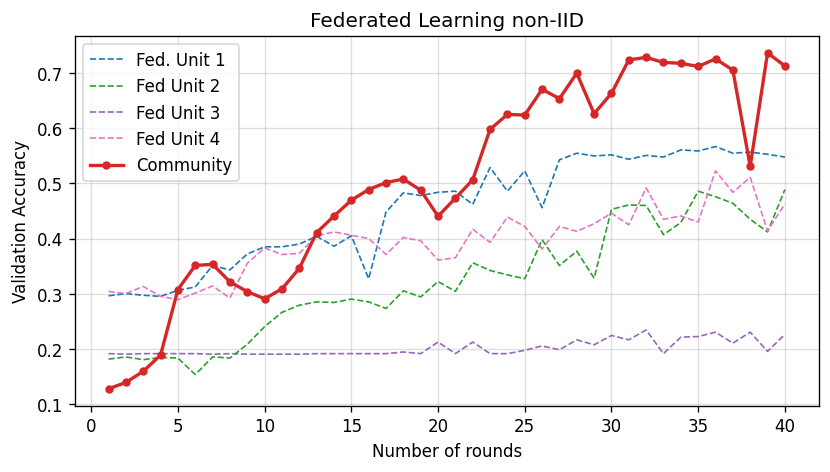

In [24]:
plt.figure(dpi=120, figsize=(8, 4))

# Client
y1 = [log['vaidation_accuracy'] for log in client[0].logs if log['type'] == 'validation']
y2 = [log['vaidation_accuracy'] for log in client[1].logs if log['type'] == 'validation']
y3 = [log['vaidation_accuracy'] for log in client[2].logs if log['type'] == 'validation']
y4 = [log['vaidation_accuracy'] for log in client[3].logs if log['type'] == 'validation']
# #unfederated
# y1_uf = [log['vaidation_accuracy'] for log in unfederated_client[0].logs if log['type'] == 'validation']
# y2_uf = [log['vaidation_accuracy'] for log in unfederated_client[1].logs if log['type'] == 'validation']
# y3_uf = [log['vaidation_accuracy'] for log in unfederated_client[2].logs if log['type'] == 'validation']
# y4_uf = [log['vaidation_accuracy'] for log in unfederated_client[3].logs if log['type'] == 'validation']


x = numpy.array(range(len(y1))) + 1
plt.plot(x, y1, '--', color='tab:blue', label='Fed. Unit 1', lw=1)
plt.plot(x, y2, '--', color='tab:green', label='Fed Unit 2', lw=1)
plt.plot(x, y3, '--', color='tab:purple', label='Fed Unit 3', lw=1)
plt.plot(x, y4, '--', color='tab:pink', label='Fed Unit 4', lw=1)


# Community
x = (numpy.array(range(len(community.logs))) + 1)
y = [log['vaidation_accuracy'] for log in community.logs]
plt.plot(x, y, 'o-', color='tab:red', label='Community', lw=2, ms=4)

plt.title('Federated Learning non-IID')
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of rounds')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

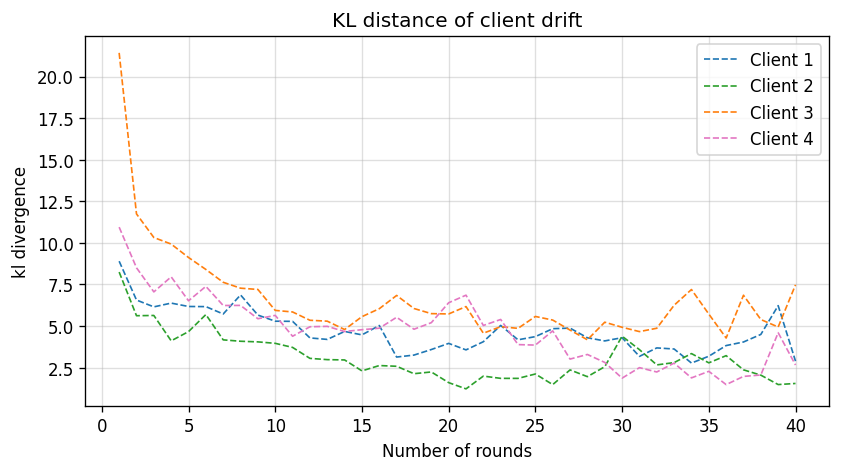

In [25]:
plt.figure(dpi=120, figsize=(8, 4))

# Client
y1 = client[0].rounds_mean_kl
y2 = client[1].rounds_mean_kl
y3 = client[2].rounds_mean_kl
y4 = client[3].rounds_mean_kl
x = numpy.array(range(len(y1))) + 1
plt.plot(x, y1, '--', color='tab:blue', label='Client 1', lw=1)
plt.plot(x, y2, '--', color='tab:green', label='Client 2', lw=1)
plt.plot(x, y3, '--', color='tab:orange', label='Client 3', lw=1)
plt.plot(x, y4, '--', color='tab:pink', label='Client 4', lw=1)

# Community
# x = (numpy.array(range(len(community.logs))) + 1)
# y = [log['vaidation_accuracy'] for log in community.logs]
# plt.plot(x, y, 'o-', color='tab:red', label='Community', lw=2, ms=4)

plt.title('KL distance of client drift')
plt.ylabel('kl divergence')
plt.xlabel('Number of rounds')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

# Different ratio to update the community model :

In [ ]:
client = {}
for i in range(4):
    client[i] = Learner(
        train_dataset=partial_train_dataset[i],
        valid_dataset=partial_valid_dataset[i]
    )
    # unfederated_client[i] = Learner(
    #     train_dataset = partial_train_dataset[i],
    #     valid_dataset = partial_valid_dataset[i]

    # )

In [ ]:
community = Learner(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset
)

In [ ]:
def assert_equals(list1, list2):

    result = True

    for a, b in zip(list1, list2):
        if a.all() == b.all():
            result = False
            break

    return result

from math import log2
def kl_divergence(p, q):
 return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

for r in range(20):
    print(community.get_control_variate().pred_c)
    print(f'\n*** Round {r}')

    print(f'--- Distributing Weights Among Clients')
    for c in range(4):
        client[c].model.set_weights(community.model.get_weights())

    for c in range(4):
        print(f'--- Training Client : Federated unit {c}')
        kl_divergence_results = []
        pre_training_logits = client[c].model(vis_x_valid, training=False)
        client[c].train(community.model.get_weights(),community.get_control_variate(),verbose=True, log=True)
        post_training_logits = client[c].model(vis_x_valid, training = False)
        for i in range(pre_training_logits.shape[0]):
            softmax_pre = tensorflow.nn.softmax(pre_training_logits[i])
            softmax_post = tensorflow.nn.softmax(post_training_logits[i])
            kl_divergence_results.append(kl_divergence(softmax_pre, softmax_post))

        np_kl = numpy.array(kl_divergence_results)
        mean_kl = np_kl.mean()
        #print(np_kl)
        #print(f'--- Mean KL Divergence: {mean_kl}')
        client[c].rounds_mean_kl.append(mean_kl)
        client[c].validate(verbose=True, log=True)

    print(f'--- Collecting Weights')
    weights = [[] for _ in range(len(community.model.get_weights()))]
    conv1_weights = []
    conv1_weights_bias = []
    conv2_weights = []
    conv2_weights_bias = []
    flatten1_weights = []
    flatten1_weights_bias = []
    flatten2_weights = []
    pred_weights = []

    conv1_c = []
    conv1_bias_c = []
    conv2_c = []
    conv2_bias_c = []
    flatten1_c = []
    flatten1_bias_c = []
    flatten2_c = []
    pred_c = []


    for c in range(4):
        #Here is where the updation of the server model happens. But this needs to happen after training each client
        # so maybe I need to add a server based function in the learner.
        #conv1_weights.append(client[c].delta_y_client.conv1_weights)
        conv1_c.append(client[c].delta_c_client.conv1_c)

        #conv1_weights_bias.append(client[c].delta_y_client.conv1_weights_bias)
        #conv1_bias_c.append(client[c].delta_c_client.conv1_bias_c)

        #conv2_weights.append(client[c].delta_y_client.conv2_weights)
        conv2_c.append(client[c].delta_c_client.conv2_c)

        #conv2_weights_bias.append(client[c].delta_y_client.conv2_weights_bias)
        #conv2_bias_c.append(client[c].delta_c_client.conv2_bias_c)

        #flatten1_weights.append(client[c].delta_y_client.flatten1_weights)
        flatten1_c.append(client[c].delta_c_client.flatten1_c)

        #flatten1_weights_bias.append(client[c].delta_y_client.flatten1_weights_bias)
        #flatten1_bias_c.append(client[c].delta_c_client.flatten1_bias_c)

        #flatten2_weights.append(client[c].delta_y_client.flatten2_weights)
        flatten2_c.append(client[c].delta_c_client.flatten2_c)

        #pred_weights.append(client[c].delta_y_client.pred_weights)
        pred_c.append(client[c].delta_c_client.pred_c)



    # print(f'--- Averaging Weights')
    # averaged = [
    #     0.6*c + 0.4*numpy.array(w).mean(axis=0)
    #     for c, w in zip(community.model.get_weights(), weights)]

    print(f'--- Sending Weights to the Community Model ')
    community_model_weights = community.model.get_weights()
    #container = ModelWeights()
    #container.assignWeights(community_model_weights)

    # b4 = community.model.get_weights()
    # averaged[1] = community.model.weights[1]
    # averaged[3] = community.model.weights[3]
    # averaged[5] = community.model.weights[5]
    # for i in range(len(community_model_weights)):
    #   print("Weight updation \n")
    #   print("Community ",community.model.weights[i].shape)
    #   #print("averaged ",averaged[i].shape)

    #   community.model.weights[i] = community.model.weights[i] + 0*(averaged[i])
    # #check_comm_after = community.model.weights[0]


    averaged_c = []
    avg = tensorflow.reduce_mean(conv1_c,axis=0)
    print("Avg hsape: ",avg.shape)
    averaged_c.append(tensorflow.reduce_mean(conv1_c,axis=0))
    #averaged_c.append(tensorflow.reduce_mean(conv1_bias_c,axis=0))
    averaged_c.append([])
    averaged_c.append(tensorflow.reduce_mean(conv2_c,axis=0))
    averaged_c.append([])
    #averaged_c.append(tensorflow.reduce_mean(conv2_bias_c,axis=0))
    averaged_c.append(tensorflow.reduce_mean(flatten1_c,axis=0))
    averaged_c.append([])
    #averaged_c.append(tensorflow.reduce_mean(flatten1_bias_c,axis=0))
    averaged_c.append(tensorflow.reduce_mean(flatten2_c,axis=0))
    averaged_c.append(tensorflow.reduce_mean(pred_c,axis=0))

    community.control_variate.conv1_c = tensorflow.math.add(community.control_variate.conv1_c,averaged_c[0])
    #community.control_variate.conv1_bias_c += averaged_c[1]
    community.control_variate.conv2_c = tensorflow.math.add(community.control_variate.conv2_c,averaged_c[2])
    #community.control_variate.conv2_bias_c += averaged_c[3]
    community.control_variate.flatten1_c += averaged_c[4]
    #community.control_variate.flatten1_bias_c += averaged_c[5]
    community.control_variate.flatten2_c += averaged_c[6]
    community.control_variate.pred_c += averaged_c[7]



    print(f'--- Collecting Weights')
    weights = [[] for _ in range(len(community.model.get_weights()))]

    for c in range(4):
        for i, w in enumerate(client[c].model.get_weights()):
            weights[i].append(w)

    print(f'--- Averaging Weights')


    if(r < 20):
      weight_for_avg_clients = 0.5
      weight_for_community = 0.5

    else:
      weight_for_avg_clients = 1
      weight_for_community = 0


    #averaged = [numpy.array(w).mean(axis=0) for w in weights]
    averaged = [
        weight_for_community*c + weight_for_avg_clients*numpy.array(w).mean(axis=0)
        for c, w in zip(community.model.get_weights(), weights)]


    print(f'--- Sending Weights to the Community Model ')
    community.model.set_weights(averaged)
    community.validate(verbose=True, log=True)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)

*** Round 0
--- Distributing Weights Among Clients
--- Training Client : Federated unit 0
Before obj creation grads len :  [<tf.Tensor 'gradient_tape/CustomModel/conv2d_48/Conv2D/Conv2DBackpropFilter:0' shape=(5, 5, 1, 128) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/conv2d_48/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/conv2d_49/Conv2D/Conv2DBackpropFilter:0' shape=(7, 7, 128, 128) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/conv2d_49/BiasAdd/BiasAddGrad:0' shape=(128,) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/dense_24/MatMul/MatMul_1:0' shape=(1152, 512) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/dense_24/BiasAdd/BiasAddGrad:0' shape=(512,) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/predictions/MatMul/MatMul_1:0' shape=(512, 10) dtype=float32>, <tf.Tensor 'gradient_tape/CustomModel/predictions/BiasAdd/BiasAddGrad:

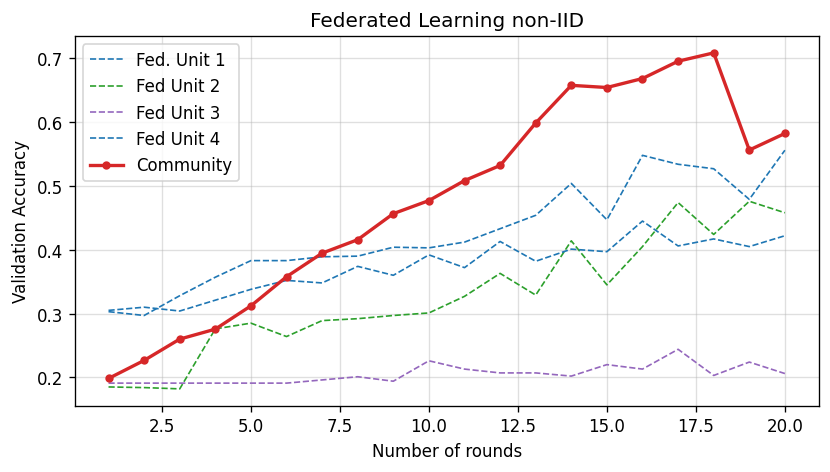

In [ ]:
plt.figure(dpi=120, figsize=(8, 4))

# Client
y1 = [log['vaidation_accuracy'] for log in client[0].logs if log['type'] == 'validation']
y2 = [log['vaidation_accuracy'] for log in client[1].logs if log['type'] == 'validation']
y3 = [log['vaidation_accuracy'] for log in client[2].logs if log['type'] == 'validation']
y4 = [log['vaidation_accuracy'] for log in client[3].logs if log['type'] == 'validation']
# #unfederated
# y1_uf = [log['vaidation_accuracy'] for log in unfederated_client[0].logs if log['type'] == 'validation']
# y2_uf = [log['vaidation_accuracy'] for log in unfederated_client[1].logs if log['type'] == 'validation']
# y3_uf = [log['vaidation_accuracy'] for log in unfederated_client[2].logs if log['type'] == 'validation']
# y4_uf = [log['vaidation_accuracy'] for log in unfederated_client[3].logs if log['type'] == 'validation']


x = numpy.array(range(len(y1))) + 1
plt.plot(x, y1, '--', color='tab:blue', label='Fed. Unit 1', lw=1)
plt.plot(x, y2, '--', color='tab:green', label='Fed Unit 2', lw=1)
plt.plot(x, y3, '--', color='tab:purple', label='Fed Unit 3', lw=1)
plt.plot(x, y4, '--', color='tab:blue', label='Fed Unit 4', lw=1)


# Community
x = (numpy.array(range(len(community.logs))) + 1)
y = [log['vaidation_accuracy'] for log in community.logs]
plt.plot(x, y, 'o-', color='tab:red', label='Community', lw=2, ms=4)

plt.title('Federated Learning non-IID')
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of rounds')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

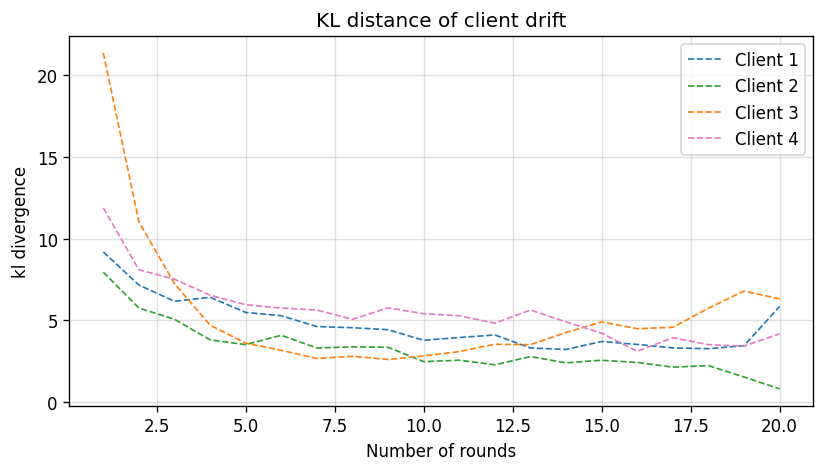

In [ ]:
plt.figure(dpi=120, figsize=(8, 4))

# Client
y1 = client[0].rounds_mean_kl
y2 = client[1].rounds_mean_kl
y3 = client[2].rounds_mean_kl
y4 = client[3].rounds_mean_kl
x = numpy.array(range(len(y1))) + 1
plt.plot(x, y1, '--', color='tab:blue', label='Client 1', lw=1)
plt.plot(x, y2, '--', color='tab:green', label='Client 2', lw=1)
plt.plot(x, y3, '--', color='tab:orange', label='Client 3', lw=1)
plt.plot(x, y4, '--', color='tab:pink', label='Client 4', lw=1)

# Community
# x = (numpy.array(range(len(community.logs))) + 1)
# y = [log['vaidation_accuracy'] for log in community.logs]
# plt.plot(x, y, 'o-', color='tab:red', label='Community', lw=2, ms=4)

plt.title('KL distance of client drift')
plt.ylabel('kl divergence')
plt.xlabel('Number of rounds')
plt.legend()
plt.grid(alpha=0.4)
plt.show()